# Python ML Labs project - Prediction of Stroke

Author: Samd Guizani

Cohort: A23 (SPOC)

## Problem Statement

The objective of the study is to propose a model that predicts whether a patient has stroke or not, based on descriptors (such as age, gender, existing discease, etc.)

The dataset contains the following variables:
1) **id**: unique patient identifier
2) **gender**: “Male”, “Female” or “Other”
3) **age**: age of the patient
4) **hypertension**: 0 (if the patient doesn’t have hypertension) or 1 (if the patient has hypertension)
5) **heart_disease**: 0 (if the patient doesn’t have a heart disease) or 1 (if the patient has a heart disease)
6) **ever_married**: “No” or “Yes”
7) **work_type**: “children”, “Govt_job”, “Never_worked”, “Private” or “Self-employed”
8) **Residence_type**: “Rural” or “Urban”
9) **avg_glucose_level**: average glucose level in the blood
10) **bmi**: body mass index
11) **smoking_status**: “formerly smoked”, “never smoked”, “smokes” or “Unknown” (in this case the information for the patient is not available)
12) **stroke**: 1 (if the patient had a stroke) or 0 (if the patient didn’t have a stroke)

**stroke** is the target variable to be predicted. It is a binary value (0 or 1), hence the model to develop is a ***classification*** model.

## Imports and loading dataset

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report

from sklearn.linear_model import LogisticRegression


In [145]:
path_to_dataset = './Inputs/stroke_data.csv'
df = pd.read_csv(path_to_dataset, sep=',', index_col='id')

In [146]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [147]:
n, d = df.shape
print(f'Number of observations: {n}')
print(f'Number of variables: {d}')

Number of observations: 5110
Number of variables: 11


In [148]:
vars = df.columns
print('List of all variables:\n')
for i, c, in enumerate(vars):
    print(i, c)

List of all variables:

0 gender
1 age
2 hypertension
3 heart_disease
4 ever_married
5 work_type
6 Residence_type
7 avg_glucose_level
8 bmi
9 smoking_status
10 stroke


In [149]:
# Group variables in continuous and categorical
continuous_vars = df.columns[[1, 7, 8]]
categorical_vars = df.columns[[0, 2, 3, 4, 5, 6, 9, 10]]

# Display levels of categorical variables
for cat_var in categorical_vars:
    print(cat_var, df[cat_var].unique()) 

gender ['Male' 'Female' 'Other']
hypertension [0 1]
heart_disease [1 0]
ever_married ['Yes' 'No']
work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ['Urban' 'Rural']
smoking_status ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke [1 0]


## Exploratory Data Analysis

In [150]:
# Display count of NA values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Exploring univariate continuous variables

In [151]:
df[continuous_vars].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


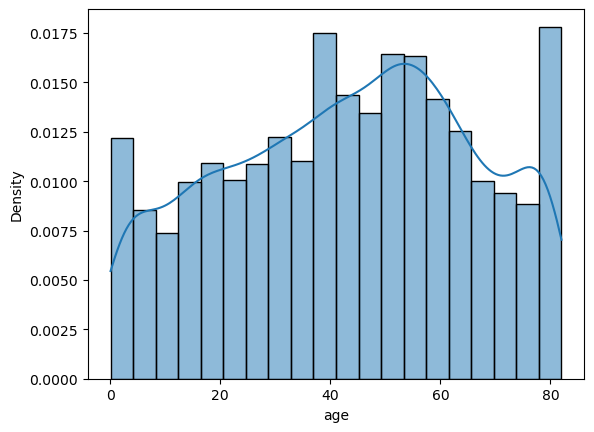

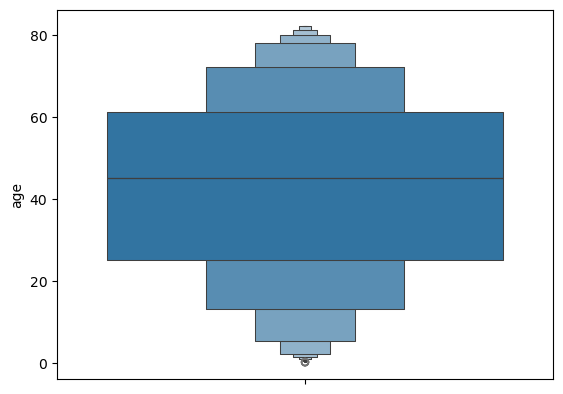

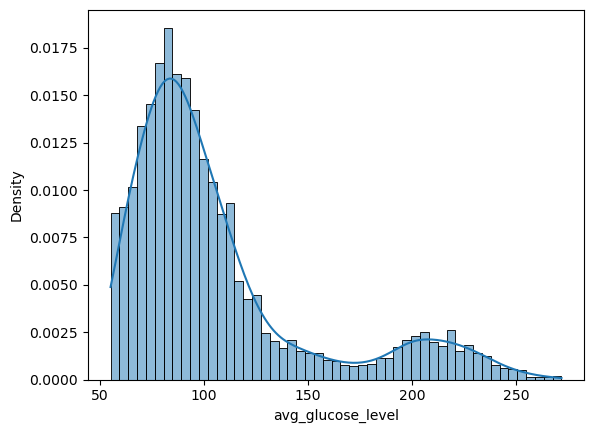

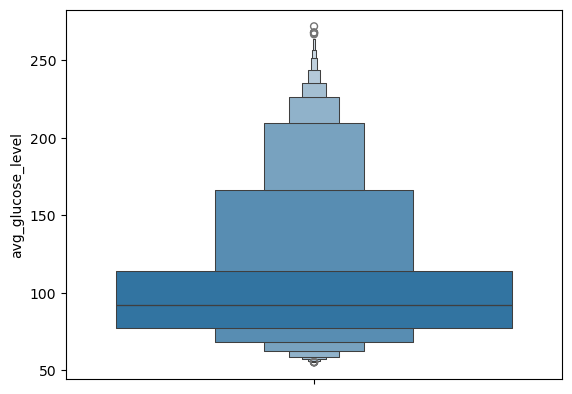

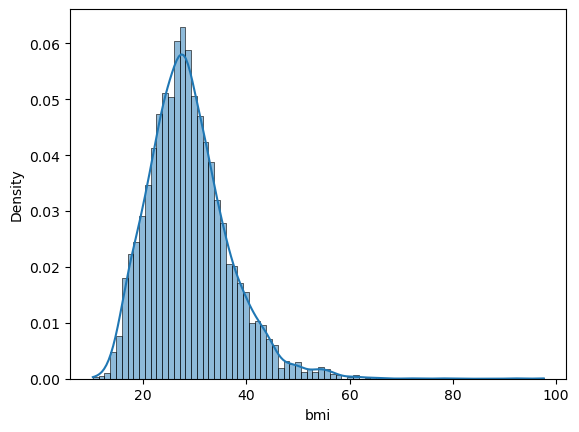

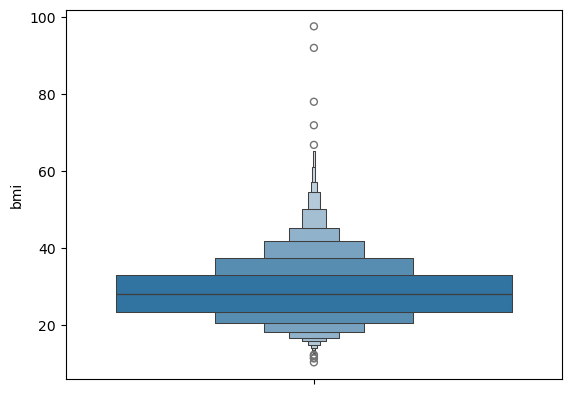

In [152]:
for cont_var in continuous_vars:
    plt.figure()
    sns.histplot(df[cont_var], kde=True, stat='density')
    plt.show()
    
    plt.figure()
    sns.boxenplot(df[cont_var])
    plt.show()

### Deeper dive in bmi >= 65 / outlier(s)?

In [153]:
df.loc[(df.bmi >= 65)].sort_values(by='bmi')

# Note: 5 observations with bmi >= 65 (unrealistic values), no stroke
# -> Decision: drop 5 outliers

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
37759,Female,53.0,0,0,Yes,Private,Rural,72.63,66.8,Unknown,0
545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0
56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0


In [154]:
df = df.drop(index=df.loc[df.bmi >= 65].index)

df.shape

(5105, 11)

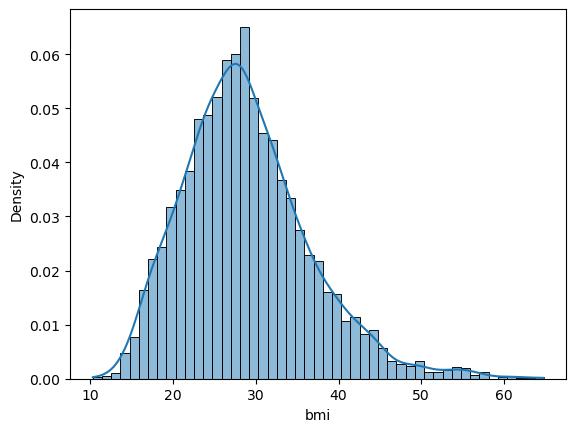

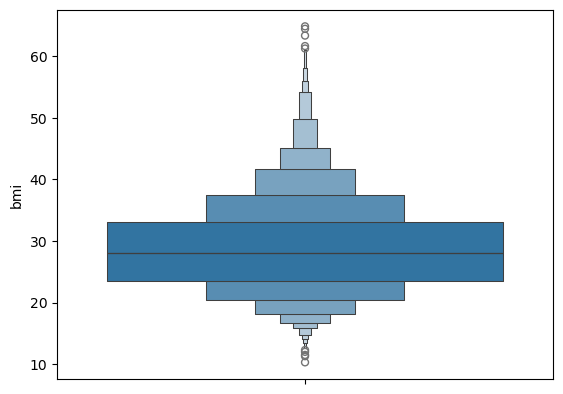

In [155]:
plt.figure()
sns.histplot(df['bmi'], kde=True, stat='density')
plt.show()

plt.figure()
sns.boxenplot(df['bmi'])
plt.show()

### Exploring univariate categorical varibales

gender
Female    2992
Male      2112
Other        1
Name: count, dtype: int64 



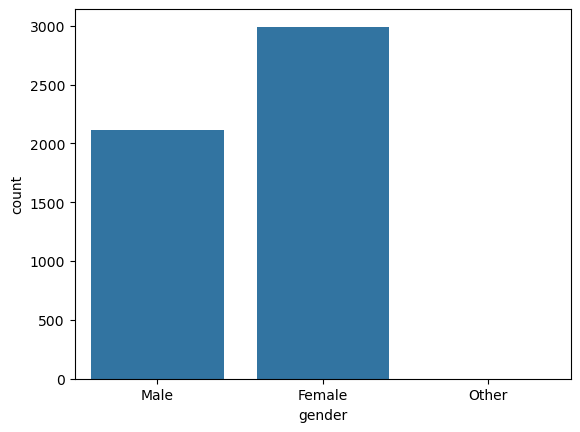

hypertension
0    4610
1     495
Name: count, dtype: int64 



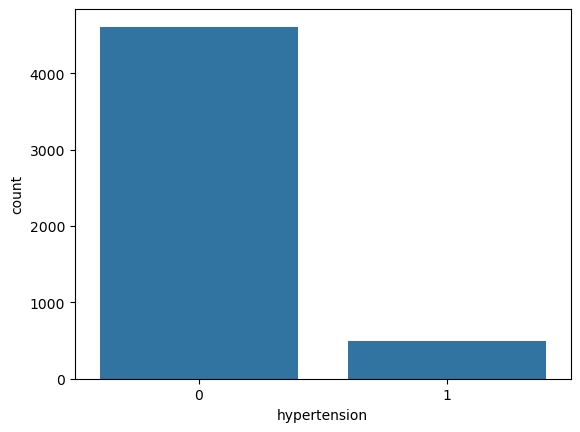

heart_disease
0    4829
1     276
Name: count, dtype: int64 



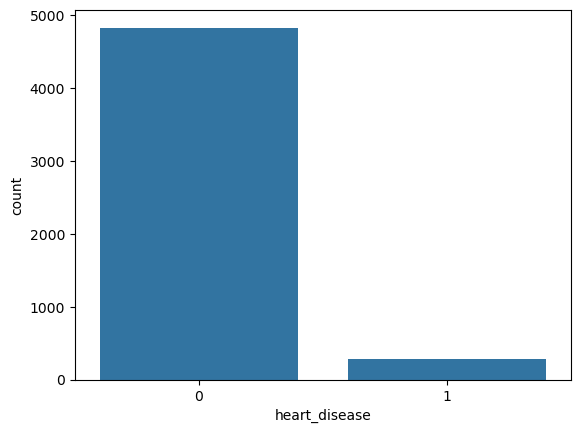

ever_married
Yes    3350
No     1755
Name: count, dtype: int64 



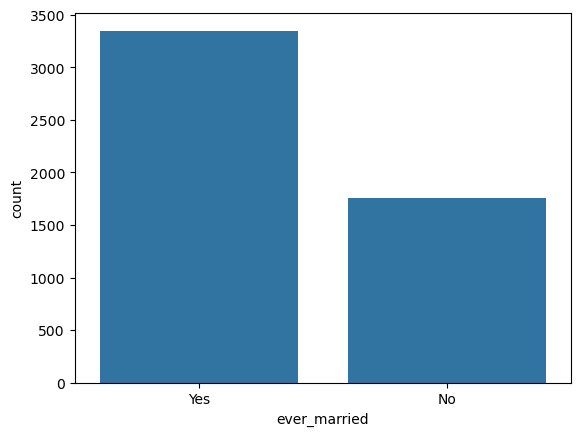

work_type
Private          2920
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64 



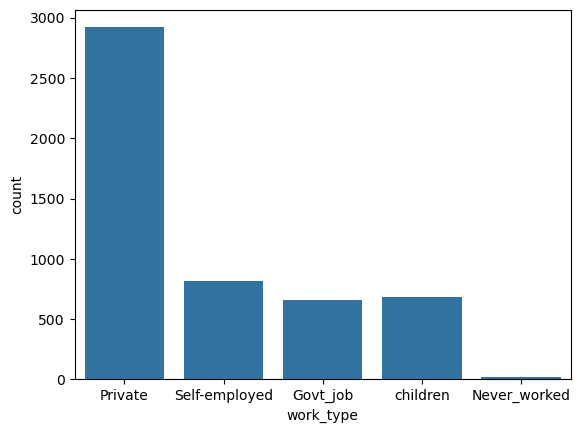

Residence_type
Urban    2595
Rural    2510
Name: count, dtype: int64 



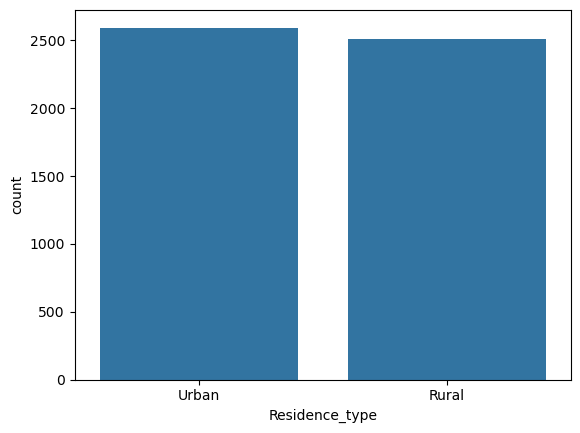

smoking_status
never smoked       1890
Unknown            1542
formerly smoked     885
smokes              788
Name: count, dtype: int64 



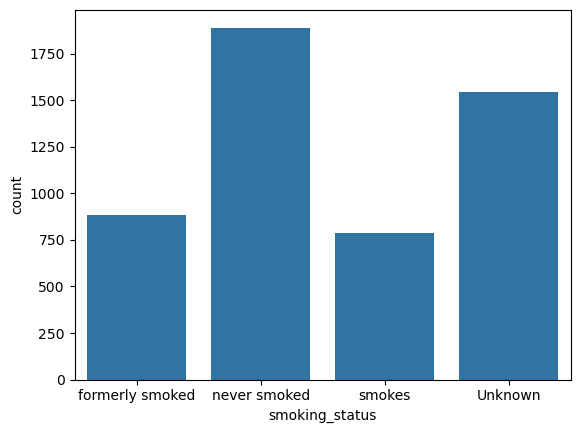

stroke
0    4856
1     249
Name: count, dtype: int64 



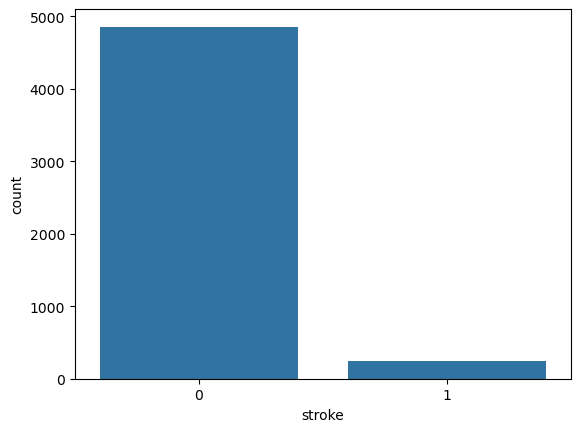

In [156]:
for cat_var in categorical_vars:
    print(df[cat_var].value_counts(), '\n')
    plt.figure()
    sns.countplot(df, x=cat_var)
    plt.show()

### Deeper dive in gender "other" category / outlier(s)?

In [157]:
df.loc[df.gender == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [158]:
# Dropping 1 observation corresponding to gender == 'Other' (only one observation, no stroke)
df = df.drop(index=df.loc[df.gender == 'Other'].index)

df.shape

(5104, 11)

### Deeper dive in work_type "Never_worked" category / grouping catgories?

In [159]:
# Exploring few observations work_type == 'Never_worked'
df.loc[df.work_type == 'Never_worked'].sort_values(by='age')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
34900,Male,13.0,0,0,No,Never_worked,Urban,85.08,14.6,Unknown,0
16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
57274,Male,14.0,0,0,No,Never_worked,Urban,137.91,41.8,never smoked,0
61219,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
69559,Male,15.0,0,0,No,Never_worked,Urban,64.29,16.7,Unknown,0
28461,Male,15.0,0,0,No,Never_worked,Rural,79.59,28.4,Unknown,0
23587,Female,16.0,0,0,No,Never_worked,Urban,84.40,25.9,never smoked,0


In [160]:
df.loc[df.work_type == 'Never_worked'].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,22.000000,22.0,22.0,22.000000,22.000000,22.0
mean,16.181818,0.0,0.0,96.042727,25.545455,0.0
std,2.342899,0.0,0.0,28.697132,7.441757,0.0
min,13.000000,0.0,0.0,59.990000,14.600000,0.0
25%,14.250000,0.0,0.0,78.457500,20.975000,0.0
50%,16.000000,0.0,0.0,86.020000,23.150000,0.0
75%,17.000000,0.0,0.0,112.807500,28.350000,0.0
max,23.000000,0.0,0.0,161.280000,44.900000,0.0


In [161]:
df.loc[df.work_type == 'children'].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,687.000000,687.0,687.000000,687.000000,671.000000,687.000000
mean,6.841339,0.0,0.001456,94.400277,20.038003,0.002911
std,4.533364,0.0,0.038152,26.658955,4.540639,0.053916
min,0.080000,0.0,0.000000,55.340000,10.300000,0.000000
25%,2.000000,0.0,0.000000,76.255000,17.150000,0.000000
50%,6.000000,0.0,0.000000,90.220000,18.900000,0.000000
75%,11.000000,0.0,0.000000,108.710000,21.600000,0.000000
max,16.000000,0.0,1.000000,219.810000,41.700000,1.000000


In [162]:
# NB: very similar distributions between df.work_type == 'children' and df.work_type == 'Never_worked' 
# -> Decision to consolidate them in one category 'children' 

df.loc[df.work_type == 'Never_worked', 'work_type'] = 'children'

work_type
Private          2919
Self-employed     819
children          709
Govt_job          657
Name: count, dtype: int64 



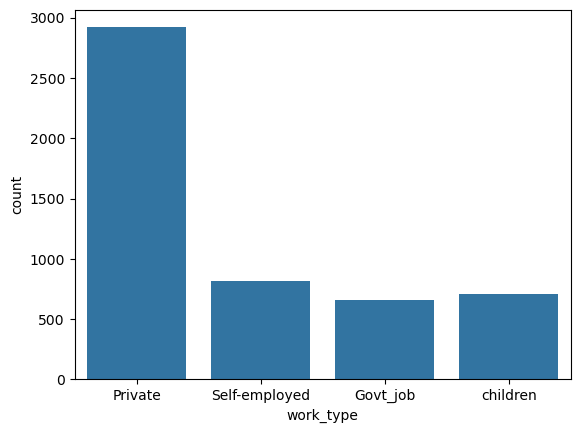

In [163]:
print(df['work_type'].value_counts(), '\n')
plt.figure()
sns.countplot(df, x='work_type')
plt.show()

### Exploring bivariate correlations

#### Pairwise correlation between continuous variables

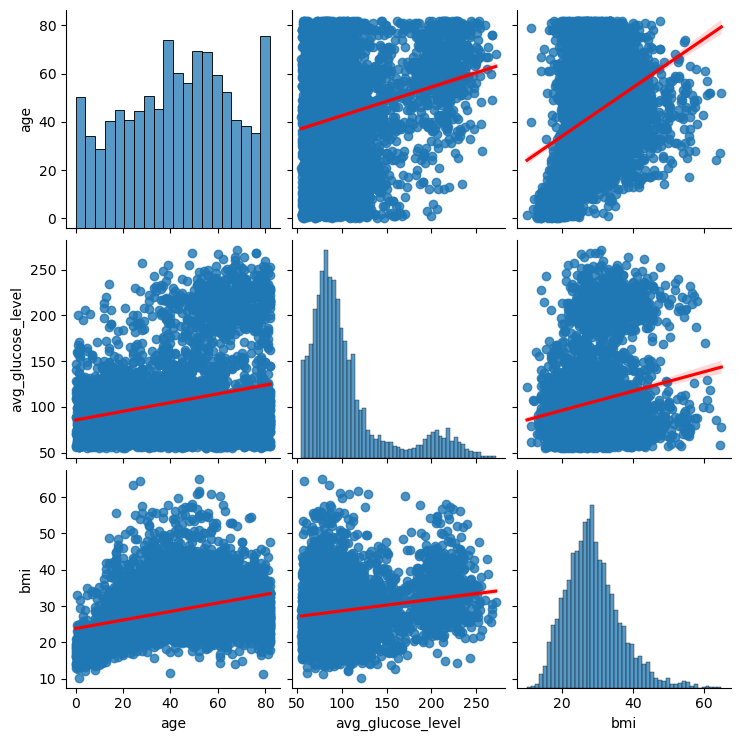

In [164]:
sns.pairplot(df[continuous_vars], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

#### Exploring correlation of continuous variables against target "stroke"

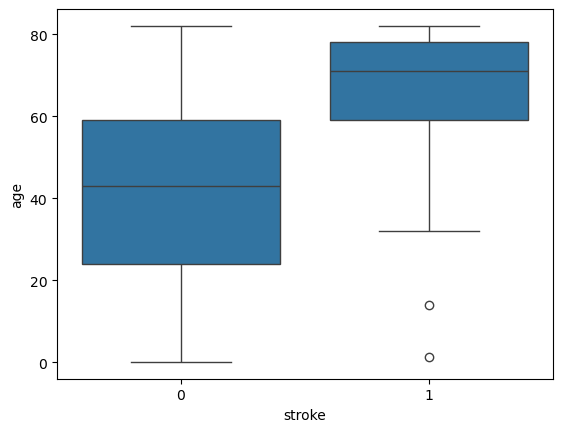

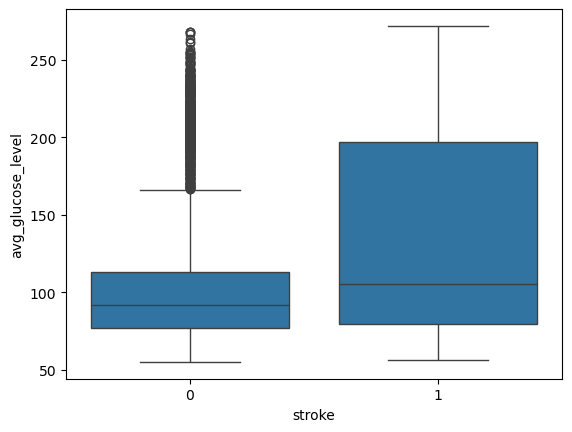

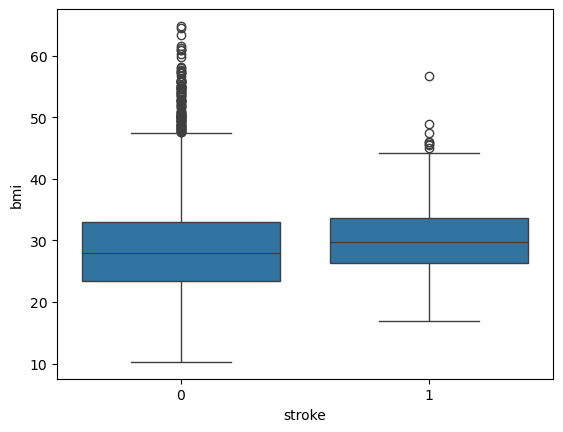

In [165]:
for cont_var in continuous_vars:
    plt.figure()
    sns.boxplot(df, x='stroke', y=cont_var)
    plt.show()

stroke         0         1
gender                    
Female  0.952874  0.047126
Male    0.948864  0.051136


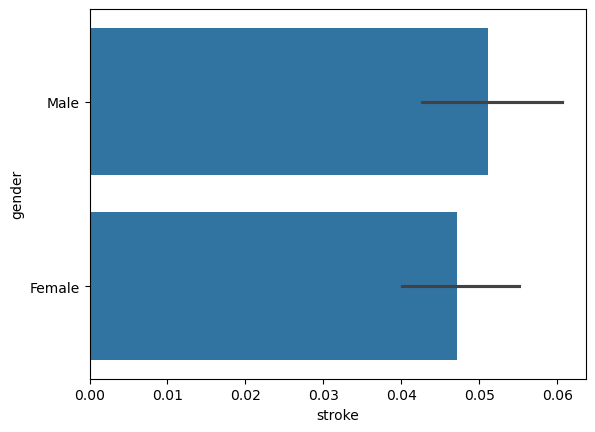

stroke               0         1
hypertension                    
0             0.960295  0.039705
1             0.866667  0.133333


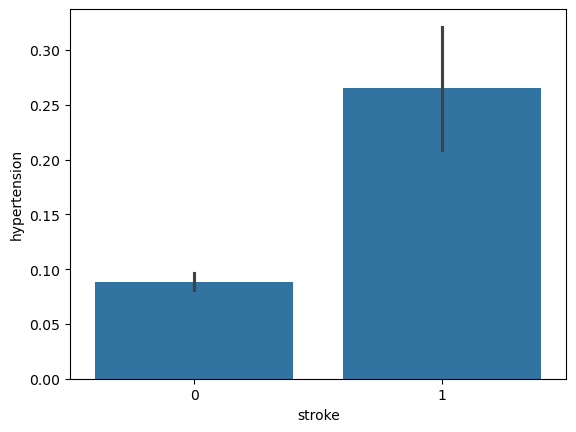

stroke                0         1
heart_disease                    
0              0.958161  0.041839
1              0.829710  0.170290


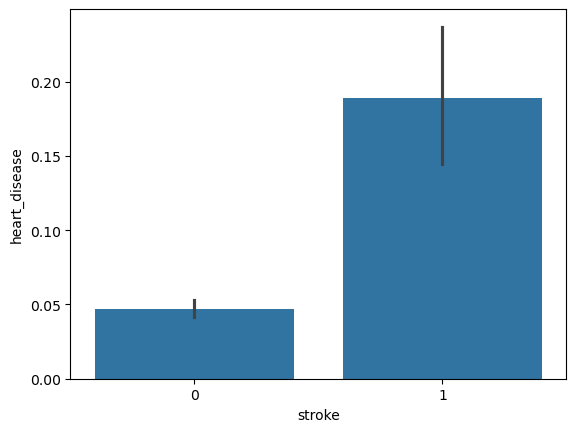

stroke               0         1
ever_married                    
No            0.983466  0.016534
Yes           0.934328  0.065672


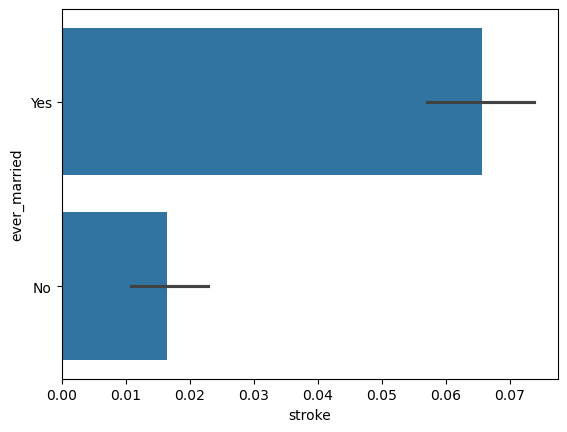

stroke                0         1
work_type                        
Govt_job       0.949772  0.050228
Private        0.948955  0.051045
Self-employed  0.920635  0.079365
children       0.997179  0.002821


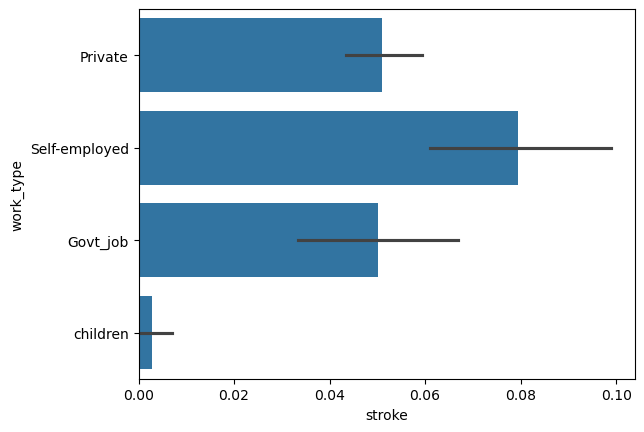

stroke                 0         1
Residence_type                    
Rural           0.954564  0.045436
Urban           0.947977  0.052023


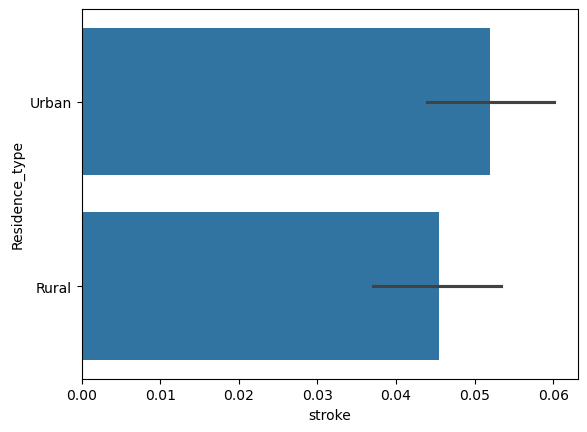

stroke                  0         1
smoking_status                     
Unknown          0.969520  0.030480
formerly smoked  0.920814  0.079186
never smoked     0.952381  0.047619
smokes           0.946701  0.053299


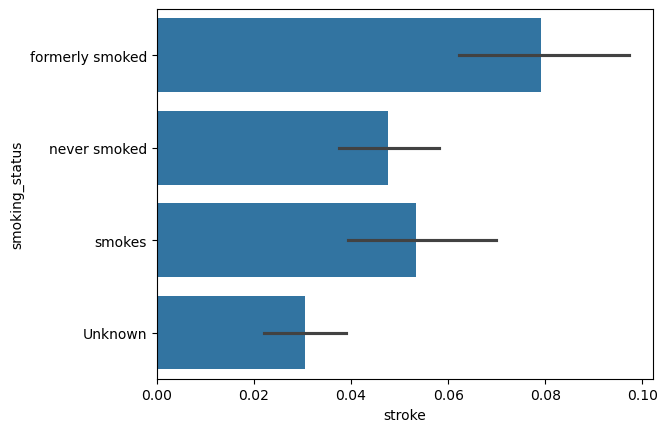

stroke    0    1
stroke          
0       1.0  0.0
1       0.0  1.0


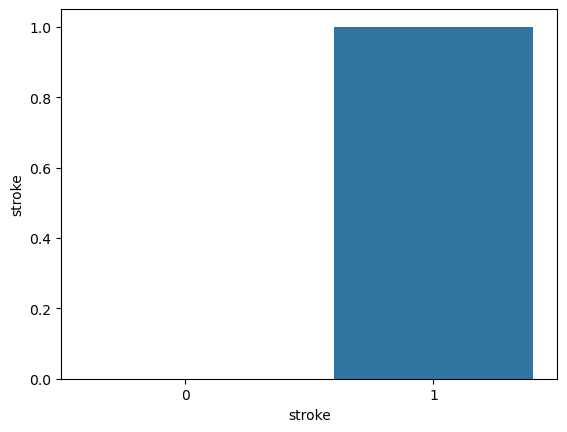

In [166]:
# Exploring pairwise correlations between categorical variables 
for cat_var in categorical_vars:
    contingency_table = pd.crosstab(df[cat_var], df['stroke'])
    print(contingency_table.div(contingency_table.sum(axis=1), axis=0)) # odds ratio
    plt.figure()
    sns.barplot(df, x='stroke', y=cat_var)
    plt.show()

#### Deeper dive in missing BMI values 

In [167]:
df.loc[df.bmi.isna()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


In [168]:
df.loc[df.bmi.isna()].stroke.value_counts()

# Note: significant number of missing bmi patients had a stroke, cannot discard them.
# -> Decision to keep them but find a way to fill the missing bmi values, or use classification method which are robust to nan values

stroke
0    161
1     40
Name: count, dtype: int64

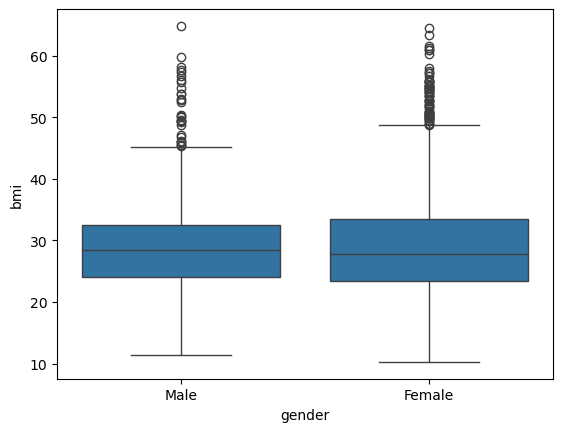

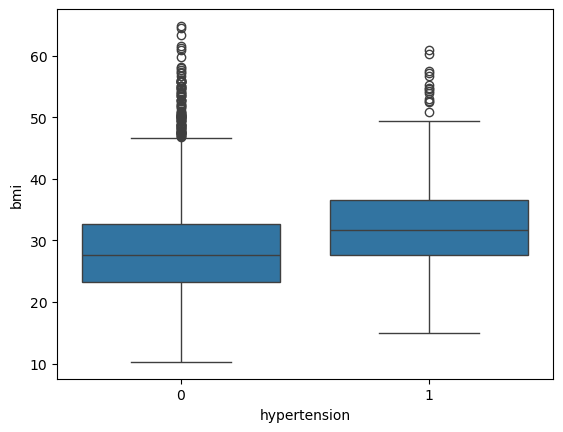

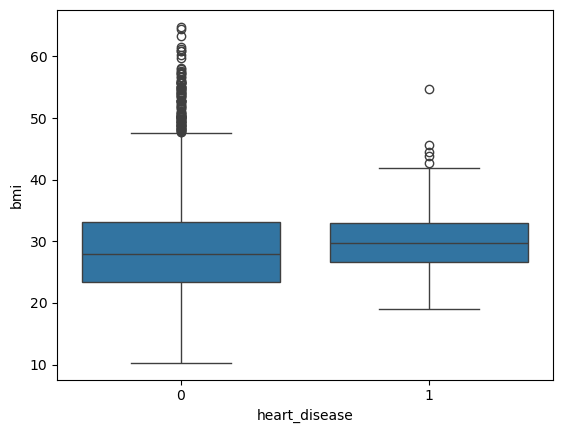

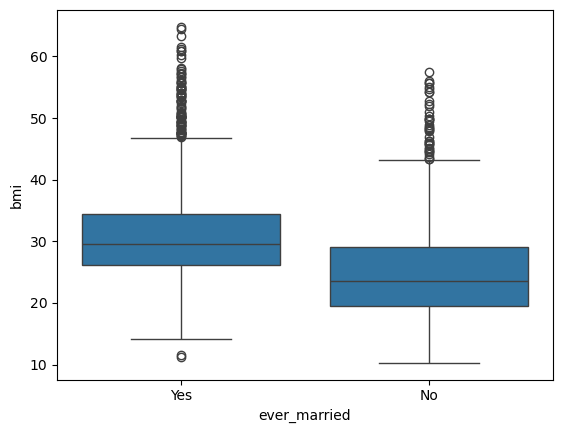

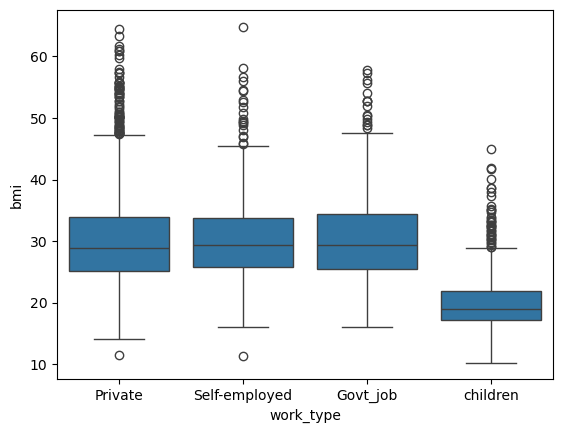

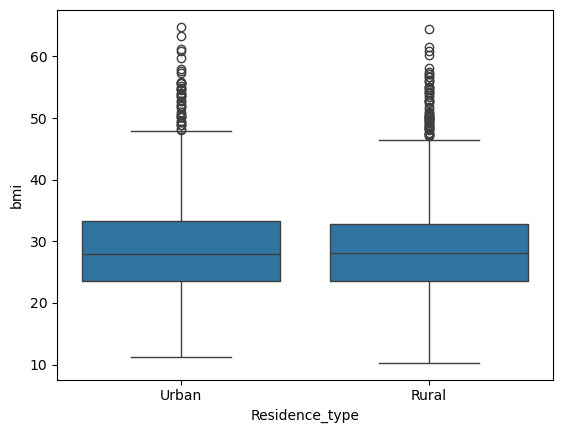

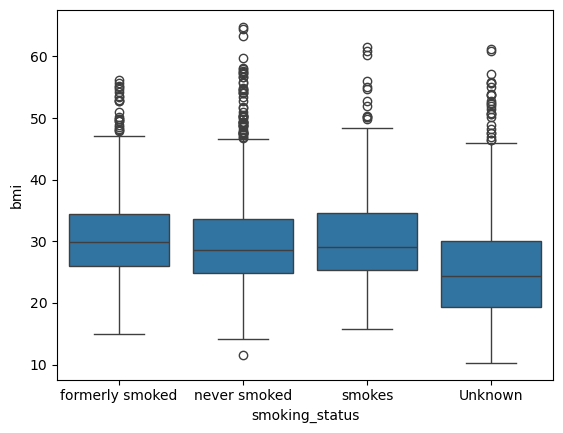

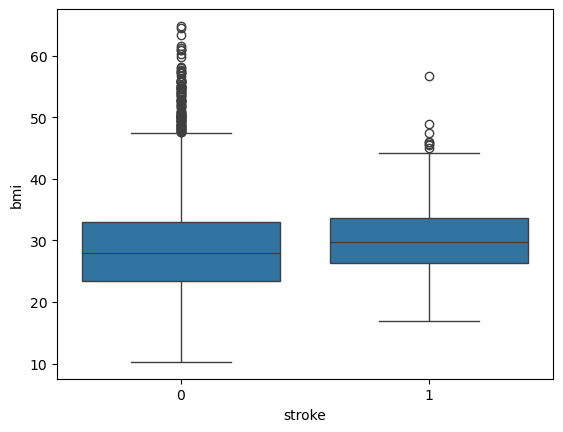

In [169]:
for cat_var in categorical_vars:
    plt.figure()
    sns.boxplot(df, x=cat_var, y='bmi')

## Features Engineering

In [170]:
# Make a copy of the original dataframe
df_preprocessed = df.copy(deep=True)

### Converting categorical variables using one hot encoding 

In [171]:
df_preprocessed.gender = pd.get_dummies(df.gender, drop_first=True)
df_preprocessed.ever_married = pd.get_dummies(df.ever_married, drop_first=True)
df_preprocessed.Residence_type = pd.get_dummies(df.Residence_type, drop_first=True)

df_preprocessed = pd.concat([df_preprocessed,pd.get_dummies(df_preprocessed.work_type, drop_first=True)],axis=1).drop(columns="work_type")
df_preprocessed = pd.concat([df_preprocessed,pd.get_dummies(df_preprocessed.smoking_status, drop_first=True)],axis=1).drop(columns="smoking_status")

In [172]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [173]:
df_preprocessed

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Private,Self-employed,children,formerly smoked,never smoked,smokes
id,,,,,,,,,,,,,,,
9046,True,67.0,0,1,True,True,228.69,36.6,1,True,False,False,True,False,False
51676,False,61.0,0,0,True,False,202.21,NaN,1,False,True,False,False,True,False
31112,True,80.0,0,1,True,False,105.92,32.5,1,True,False,False,False,True,False
60182,False,49.0,0,0,True,True,171.23,34.4,1,True,False,False,False,False,True
1665,False,79.0,1,0,True,False,174.12,24.0,1,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,False,80.0,1,0,True,True,83.75,NaN,0,True,False,False,False,True,False
44873,False,81.0,0,0,True,True,125.20,40.0,0,False,True,False,False,True,False
19723,False,35.0,0,0,True,False,82.99,30.6,0,False,True,False,False,True,False


In [174]:
df_preprocessed.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5104.000000,5104.000000,5104.000000,5104.000000,4903.000000,5104.000000
mean,43.238440,0.096983,0.054075,106.151957,28.841158,0.048785
std,22.619359,0.295963,0.226188,45.268854,7.668948,0.215440
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.287500,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.890000,28.000000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,64.800000,1.000000


### Impute missing BMI values based on correlations with other variables

In [175]:
imp = IterativeImputer(max_iter=10, random_state=1235)
imp.fit(df_preprocessed)

df_preprocessed_bmi_filled = pd.DataFrame(imp.transform(df_preprocessed), columns=df_preprocessed.columns, index=df_preprocessed.index)

In [176]:
df_preprocessed_bmi_filled

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Private,Self-employed,children,formerly smoked,never smoked,smokes
id,,,,,,,,,,,,,,,
9046,1.0,67.0,0.0,1.0,1.0,1.0,228.69,36.600000,1.0,1.0,0.0,0.0,1.0,0.0,0.0
51676,0.0,61.0,0.0,0.0,1.0,0.0,202.21,31.364810,1.0,0.0,1.0,0.0,0.0,1.0,0.0
31112,1.0,80.0,0.0,1.0,1.0,0.0,105.92,32.500000,1.0,1.0,0.0,0.0,0.0,1.0,0.0
60182,0.0,49.0,0.0,0.0,1.0,1.0,171.23,34.400000,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1665,0.0,79.0,1.0,0.0,1.0,0.0,174.12,24.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,0.0,80.0,1.0,0.0,1.0,1.0,83.75,32.004535,0.0,1.0,0.0,0.0,0.0,1.0,0.0
44873,0.0,81.0,0.0,0.0,1.0,1.0,125.20,40.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0
19723,0.0,35.0,0.0,0.0,1.0,0.0,82.99,30.600000,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [177]:
df_preprocessed_bmi_filled.describe()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Private,Self-employed,children,formerly smoked,never smoked,smokes
count,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000,5104.000000
mean,0.413793,43.238440,0.096983,0.054075,0.656348,0.508425,106.151957,28.886272,0.048785,0.571904,0.160462,0.138911,0.173197,0.370298,0.154389
std,0.492561,22.619359,0.295963,0.226188,0.474973,0.499978,45.268854,7.548444,0.215440,0.494851,0.367070,0.345887,0.378455,0.482932,0.361356
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.287500,23.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,91.890000,28.300000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,1.000000,114.090000,32.900000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,64.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


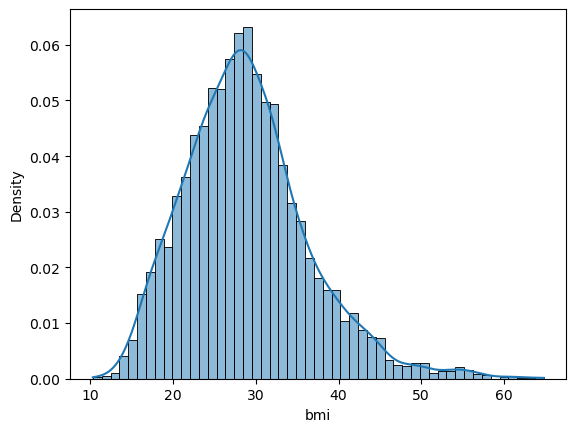

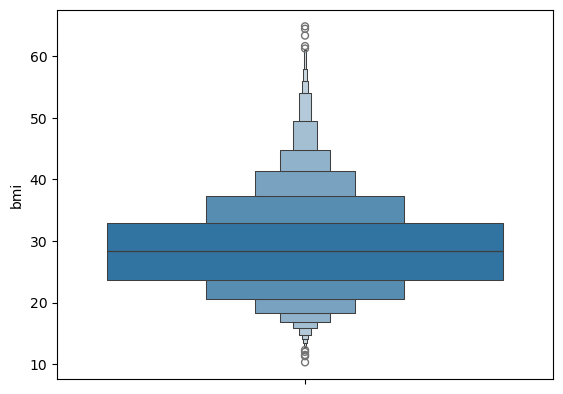

In [178]:
plt.figure()
sns.histplot(df_preprocessed_bmi_filled.bmi, kde=True, stat='density')
plt.show()

plt.figure()
sns.boxenplot(df_preprocessed_bmi_filled.bmi)
plt.show()

In [179]:
df.bmi.describe()

count    4903.000000
mean       28.841158
std         7.668948
min        10.300000
25%        23.500000
50%        28.000000
75%        33.100000
max        64.800000
Name: bmi, dtype: float64

In [180]:
df_preprocessed_bmi_filled.bmi.describe()

count    5104.000000
mean       28.886272
std         7.548444
min        10.300000
25%        23.700000
50%        28.300000
75%        32.900000
max        64.800000
Name: bmi, dtype: float64

## Modelling

### Dataset df_preprocessed_bmi_filled

In [215]:
df_train, df_test = train_test_split(df_preprocessed_bmi_filled, test_size = 0.25, random_state=19780731, stratify=df_preprocessed_bmi_filled.stroke)

feature_names = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'Private',
       'Self-employed', 'children', 'formerly smoked', 'never smoked',
       'smokes']


# get values of training data
X_train = df_train.loc[:,feature_names].values
y_train = df_train.stroke.values

# get the values of the columns for the test data
X_test = df_test.loc[:,feature_names].values
y_test = df_test.stroke.values

In [258]:
# Initialize model
model = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced')

# Search best model hyper-parameters
grid_search_param = [{'C': [0.001, 0.01, 0.1, 1, 10]}]
grid_search_cv = 5
grid_search_scoring = 'f1'

grid_search = GridSearchCV(model, param_grid=grid_search_param, cv=grid_search_cv, scoring=grid_search_scoring)
grid_search.fit(X=X_train, y=y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Fit model with best hyper-parameters 
model = grid_search.best_estimator_.fit(X=X_train, y=y_train)


# Test model
y_test_predicted = model.predict(X_test)

# Evaluate model
cf = pd.DataFrame(index=["y_test_0","y_test_1"],columns=["y_pred_0","y_pred_1"])
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)

recall_score(y_true=y_test, y_pred=y_test_predicted)
precision_score(y_true=y_test, y_pred=y_test_predicted)

report = classification_report(y_true=y_test, y_pred=y_test_predicted)

Best parameters: {'C': 10}
Best score: 0.2324162873261253


In [267]:
class Classifier(object):
    
    def __init__(self, model, X_train, y_train, X_test, y_test, grid_search_param, grid_search_cv=5, grid_search_scoring='f1'):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.grid_search_param = grid_search_param
        self.grid_search_cv = grid_search_cv
        self.grid_search_scoring = grid_search_scoring
        self.fitted_model = self.trainModel()
        self.y_test_predicted = self.testModel()
        self.cf, self.recall, self.precision, self.report = self.evaluateModel()
        
    def trainModel(self):
        grid_search = GridSearchCV(self.model, param_grid=self.grid_search_param, cv=self.grid_search_cv, scoring=self.grid_search_scoring)
        grid_search.fit(X=self.X_train, y=self.y_train)
        print("Best parameters:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return grid_search.best_estimator_.fit(X=self.X_train, y=y_train)
    
    def testModel(self):
        return self.fitted_model.predict(self.X_test)
    
    def evaluateModel(self):
        # Confusion matrix
        cf = pd.DataFrame(index=["y_test_0","y_test_1"],columns=["y_pred_0","y_pred_1"])
        cf.loc[:,:] = confusion_matrix(y_true= self.y_test,y_pred= self.y_test_predicted)
        
        recall = recall_score(y_true=self.y_test, y_pred=self.y_test_predicted)
        precision = precision_score(y_true=self.y_test, y_pred=self.y_test_predicted)

        report = classification_report(y_true=y_test, y_pred=y_test_predicted)
        return cf, recall, precision, report

In [268]:
# Initialize model
lr_model = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced')

grid_search_param = [{'C': [0.001, 0.01, 0.1, 1, 10]}]
grid_search_cv = 5
grid_search_scoring = 'f1'

LogReg_classifier = Classifier(model=lr_model, 
                               X_train=X_train,
                               y_train=y_train,
                               X_test=X_test,
                               y_test=y_test,
                               grid_search_param=grid_search_param,
                               grid_search_cv=grid_search_cv,
                               grid_search_scoring=grid_search_scoring)

Best parameters: {'C': 10}
Best score: 0.2324162873261253


In [271]:
LogReg_classifier.fitted_model

LogisticRegression(C=10, class_weight='balanced', max_iter=1000, random_state=0)

In [259]:
grid_search.best_estimator_

LogisticRegression(C=10, class_weight='balanced', max_iter=1000, random_state=0)

In [260]:
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.84      1214
         1.0       0.13      0.79      0.23        62

    accuracy                           0.74      1276
   macro avg       0.56      0.76      0.54      1276
weighted avg       0.94      0.74      0.81      1276



In [261]:
cf

,y_pred_0,y_pred_1
y_test_0,896,318
y_test_1,13,49


In [262]:
y_test.sum()

62.0

In [263]:
confusion_matrix(y_true= y_test,y_pred= y_test_predicted)

array([[896, 318],
       [ 13,  49]], dtype=int64)

In [264]:
y_test_predicted.sum()

367.0

In [265]:
model.get_params()

{'C': 10,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [266]:
model

LogisticRegression(C=10, class_weight='balanced', max_iter=1000, random_state=0)